In [ ]:
import pandas as pd

# Load the training data
train_df = pd.read_csv('train.csv')

# Compute some basic descriptive statistics
num_tweets = len(train_df)
num_unique_text = len(train_df['text'].unique())
num_unique_sentiment = len(train_df['sentiment'].unique())
num_missing_text = train_df['text'].isna().sum()
num_missing_sentiment = train_df['sentiment'].isna().sum()

print(f"Number of tweets: {num_tweets}")
print(f"Number of unique tweets: {num_unique_text}")
print(f"Number of unique sentiments: {num_unique_sentiment}")
print(f"Number of missing tweets: {num_missing_text}")
print(f"Number of missing sentiments: {num_missing_sentiment}")


Number of tweets: 27481
Number of unique tweets: 27481
Number of unique sentiments: 3
Number of missing tweets: 1
Number of missing sentiments: 0


In [ ]:
# Get more detailed information about the dataset
print(train_df.describe())
print(train_df.info())


            textID                                  text selected_text  \
count        27481                                 27480         27480   
unique       27481                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27481  
unique         3  
top      neutral  
freq       11118  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


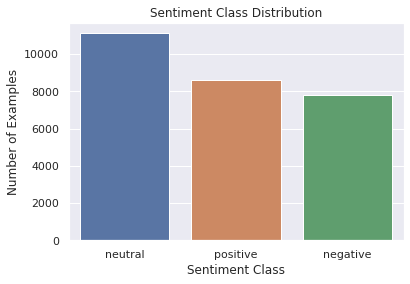

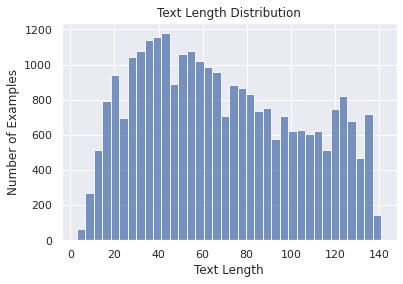

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('train.csv')

# Count the number of examples for each sentiment class
sentiment_counts = train_df['sentiment'].value_counts()

# Plot a bar chart of the sentiment class distribution
sns.set(style="darkgrid")
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Examples')
plt.show()

# Compute the length of each text in the dataset
text_lengths = train_df['text'].str.len()

# Plot a histogram of the text length distribution
sns.set(style="darkgrid")
sns.histplot(data=text_lengths)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Number of Examples')
plt.show()


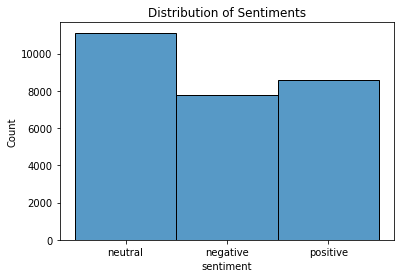

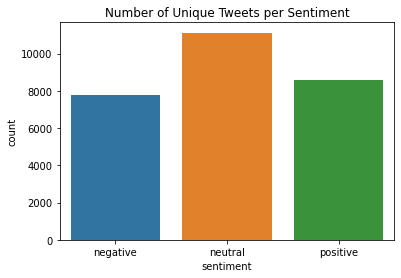

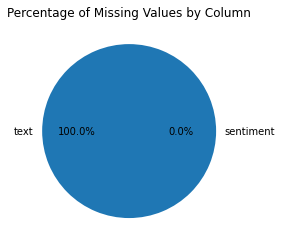

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data
train_df = pd.read_csv('train.csv')

# Compute some basic descriptive statistics
num_tweets = len(train_df)
num_unique_text = len(train_df['text'].unique())
num_unique_sentiment = len(train_df['sentiment'].unique())
num_missing_text = train_df['text'].isna().sum()
num_missing_sentiment = train_df['sentiment'].isna().sum()

# Plot a histogram of the number of tweets per sentiment
sns.histplot(train_df, x='sentiment')
plt.title('Distribution of Sentiments')
plt.show()

# Plot a bar chart of the number of unique tweets per sentiment
unique_tweets_df = train_df.drop_duplicates(subset=['text', 'sentiment'])
count_df = unique_tweets_df.groupby('sentiment')['text'].count().reset_index(name='count')
sns.barplot(data=count_df, x='sentiment', y='count')
plt.title('Number of Unique Tweets per Sentiment')
plt.show()

# Plot a pie chart of the number of missing values per column
missing_values_df = pd.DataFrame({
    'column': ['text', 'sentiment'],
    'missing_values': [num_missing_text, num_missing_sentiment]
})
plt.pie(missing_values_df['missing_values'], labels=missing_values_df['column'], autopct='%1.1f%%')
plt.title('Percentage of Missing Values by Column')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Tokenize the tweets
tokenizer = tf.keras.preprocessing.text.Tokenizer()
train['text'] = train['text'].fillna('')
tokenizer.fit_on_texts(train['text'])
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(train['text'])
X_test = tokenizer.texts_to_sequences(test['text'])

# Pad the sequences
max_len = max(len(x) for x in X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

# Encode the sentiment labels
sentiments = train['sentiment'].unique()
sentiment_map = {s: i for i, s in enumerate(sentiments)}

y_train = train['sentiment'].map(sentiment_map).values
y_test = test['sentiment'].map(sentiment_map).values

# Define the Bi-LSTM model
input_layer = Input(shape=(max_len,))
embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len)(input_layer)
dropout_layer = Dropout(0.2)(embedding_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(dropout_layer)
output_layer = TimeDistributed(Dense(len(sentiments), activation='softmax'))(lstm_layer)

# Check the shapes of the input data and labels
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=len(X_train))


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

X_train shape: (27481, 35)
y_train shape: (27481,)
Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 1.1001 - accuracy: 0.2830 - val_loss: 1.0977 - val_accuracy: 0.3753
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1.0980 - accuracy: 0.3598 - val_loss: 1.0957 - val_accuracy: 0.4128
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 1.0961 - accuracy: 0.4024 - val_loss: 1.0938 - val_accuracy: 0.4128
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 1.0943 - accuracy: 0.4025 - val_loss: 1.0920 - val_accuracy: 0.4128
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 1.0926 - accuracy: 0.4025 - val_loss: 1.0903 - val_accuracy: 0.4128
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 1.0910 - accuracy: 0.4025 - val_loss: 1.0888 - val_accuracy: 0.4128
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 1.0895 - accuracy: 0.4025 - val_loss: 1.0873 - va

NameError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Load the dataset
train_data = pd.read_csv('train.csv')

# Replace NaNs with empty strings
train_data['text'] = train_data['text'].fillna('')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['text'], train_data['sentiment'], test_size=0.2, random_state=42)

# Preprocess the data using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf.predict(X_val)

# Evaluate the performance of the classifier
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='weighted')
rec = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovr')

# Print the evaluation metrics
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(prec))
print("Recall: {:.4f}".format(rec))
print("F1 Score: {:.4f}".format(f1))


Accuracy: 0.6502
Precision: 0.6580
Recall: 0.6502
F1 Score: 0.6507
AUC-ROC Score: 0.8039


In [5]:
import pandas as pd

naive_bayes_metrics = {'Model': 'Naive Bayes', 
               'Accuracy': 0.6502, 
               'Precision': 0.6580, 
               'Recall': 0.6502, 
               'F1 Score': 0.6507}

bi_lstm_metrics = {'Model': 'bi-LSTM', 
                'Accuracy': 0.6321448783248443, 
                'Precision': 0.6335610679751617, 
                'Recall': 0.6321448783248443, 
                'F1 Score': 0.6326250693023404}

df = pd.DataFrame([naive_bayes_metrics, bi_lstm_metrics])
print(df)


         Model  Accuracy  Precision    Recall  F1 Score
0  Naive Bayes  0.650200   0.658000  0.650200  0.650700
1      bi-LSTM  0.632145   0.633561  0.632145  0.632625
